# Fit the final model and make predictions

In [1]:
library(magrittr)

## Prepare datasets

In [2]:
blacklist = readr::read_tsv('features/blacklist.tsv')$feature
feature_df = readr::read_tsv('features/transformed-features.tsv.bz2') %>%
  dplyr::select(-one_of(blacklist))

In [3]:
head(feature_df, 2)

,compound_id,compound_name,disease_id,disease_name,category,status,prior_prob,prior_logit,degree_CbG,degree_CcSE,ellip.h,dwpc_CuG<rGiGaD,dwpc_CuGaDuGaD,dwpc_CuGcG<rGaD,dwpc_CuGcGiGaD,dwpc_CuGdDpSpD,dwpc_CuGr>GbCtD,dwpc_CuGuCtD,dwpc_CuGuCtDrD,dwpc_CuGuCuGaD,dwpc_CuGuDuGaD
1,DB01048,Abacavir,DOID:10652,Alzheimer's disease,NA,0,0.004753,-5.344,-0.2955,0.8146,⋯,-0.6116,-0.5028,-0.4211,-0.4581,-0.5399,-0.357,-0.375,-0.5642,-0.5555,-0.4952
2,DB05812,Abiraterone,DOID:10652,Alzheimer's disease,NA,0,0.004753,-5.344,0.5495,0.5554,⋯,-0.6116,-0.5028,-0.4211,-0.4581,-0.5399,-0.357,-0.375,-0.5642,-0.5555,-0.4952


In [4]:
train_df = feature_df %>%
  dplyr::filter(prior_prob > 0)

X_train = train_df %>%
  dplyr::select(prior_logit, starts_with('degree_'), starts_with('dwpc_')) %>%
  as.matrix()
dim(X_train)

y_train = train_df$status

[1] 29799   138

## Fit Model

In [5]:
lambda = 'lambda.1se'
penalty = ifelse(colnames(X_train) == 'prior_logit', 0, 1)

In [6]:
fit = hetior::glmnet_train(X = X_train, y = y_train, alpha = 0.2, s = lambda, cores = 10, seed = 0,
  penalty.factor=penalty, lambda.min.ratio=1e-8, nlambda=150, standardize=TRUE)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



[1] 0.005927726

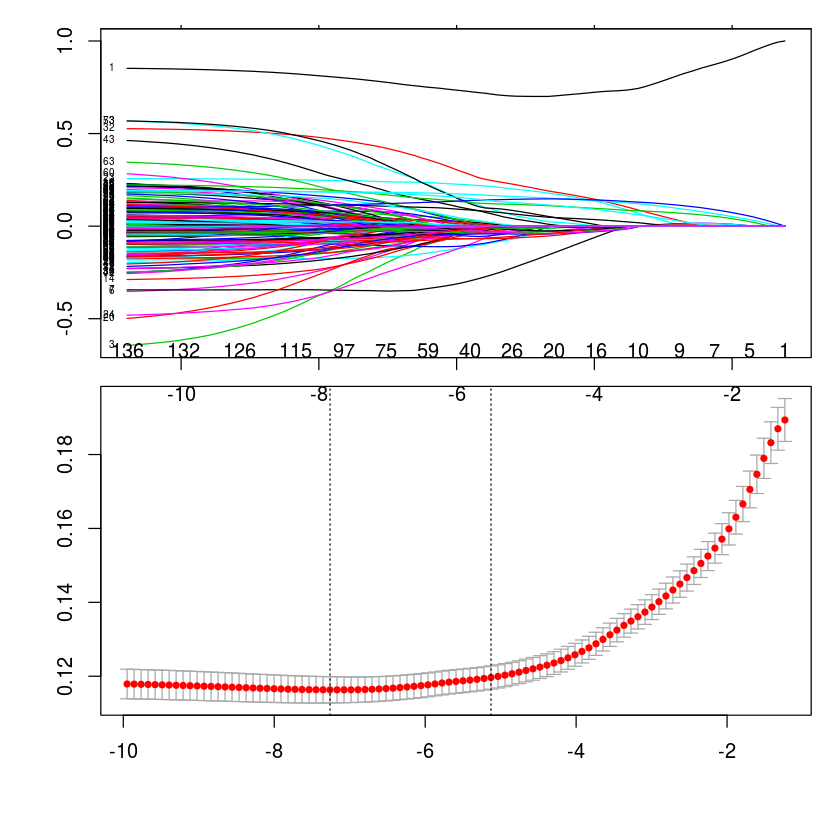

In [7]:
par(mfrow = c(2,1), oma = c(5,4,0,0) + 0.1, mar = c(0,0,1,1) + 0.1)
plot(fit$cv_model$glmnet.fit, xvar = "lambda", label = TRUE)
plot(fit$cv_model)
fit$cv_model[[lambda]]

In [8]:
# The coefficient for prior_logit should be around 1 for our approach to work well
dplyr::filter(fit$coef_df, feature == 'prior_logit')$coef

[1] 0.7017316

In [9]:
# Number of negative and positive coefficients
fit$coef_df %>%
  dplyr::filter(feature != 'intercept', zcoef != 0) %>%
  .[['zcoef']] %>% sign %>% table

.
-1  1 
18 13 

In [10]:
# Sum of prior (should sum to the number of treatments)
sum(feature_df$prior_prob)

# Prevalence of positives as percent
scales::percent(mean(feature_df$status))

[1] 754.9903

[1] "0.361%"

In [53]:
X_all = feature_df %>%
  dplyr::mutate(prior_logit = boot::logit(mean(status))) %>%
  dplyr::select(one_of(colnames(X_train))) %>%
  as.matrix()

y_predicted = hetior::glmnet_predict(fit$cv_model, X = X_all, s = lambda)
y_predicted %>% mean() %>% scales::percent()

[1] "0.286%"

In [12]:
train_pred_df = train_df %>%
  dplyr::select(compound_id, disease_id) %>%
  dplyr::bind_cols(dplyr::data_frame(training_prediction = fit$y_pred))

predict_df = feature_df %>%
  dplyr::select(compound_id:prior_prob, starts_with('status')) %>%
  dplyr::mutate(prediction = y_predicted) %>%
  dplyr::left_join(train_pred_df) %>%
  dplyr::group_by(compound_id) %>%
  dplyr::mutate(compound_percentile = dplyr::cume_dist(prediction)) %>%
  dplyr::ungroup() %>%
  dplyr::group_by(disease_id) %>%
  dplyr::mutate(disease_percentile = dplyr::cume_dist(prediction)) %>%
  dplyr::ungroup() %>%
  dplyr::left_join(readr::read_tsv('../validate/validation-statuses.tsv'))

Joining by: c("compound_id", "disease_id")
Joining by: c("compound_id", "compound_name", "disease_id", "disease_name")


In [13]:
predict_df %>%
  dplyr::arrange(desc(prediction)) %>%
  head(2)

,compound_id,compound_name,disease_id,disease_name,category,status,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral
1,DB00282,Pamidronate,DOID:11476,osteoporosis,DM,1,0.03893,0.8868986,0.9771082,1,1,NA,NA,NA
2,DB00630,Alendronate,DOID:11476,osteoporosis,DM,1,0.03893,0.8849911,0.9766821,1,0.9993498,NA,NA,NA


## Calculate performance

In [14]:
get_metrics = function(params) {
  y_true_var = params$y_true_var
  y_pred_var = params$y_pred_var
  vtm_df = predict_df[, c(y_true_var, y_pred_var)] %>% na.omit()
  y_true = vtm_df[[1]]
  vtm = hetior::calc_vtms(y_true = y_true, y_pred = vtm_df[[2]], is_prob = T)
  dplyr::data_frame(
      y_true_var = y_true_var, y_pred_var = y_pred_var,
      n_pos = sum(y_true == 1), n_neg = sum(y_true == 0),
      auroc = vtm$auroc, auprc = vtm$auprc, tjur = vtm$tjur
  ) %>% return()
}

perf_df = tidyr::crossing(
  y_pred_var = c('prediction', 'compound_percentile', 'disease_percentile', 'training_prediction', 'prior_prob'),
  y_true_var = c('status', 'status_drugcentral', 'status_trials')
) %>%
  dplyr::rowwise() %>%
  dplyr::do(get_metrics(.))

perf_df

,y_true_var,y_pred_var,n_pos,n_neg,auroc,auprc,tjur
1,status,compound_percentile,755,208413,0.9362958,0.03706945,0.4357167
2,status_drugcentral,compound_percentile,208,207572,0.8518688,0.006409814,0.3513426
3,status_trials,compound_percentile,5594,202186,0.6625427,0.0515353,0.1619315
4,status,disease_percentile,755,208413,0.9499424,0.1037369,0.4502484
5,status_drugcentral,disease_percentile,208,207572,0.8073453,0.01014896,0.3074722
6,status_trials,disease_percentile,5594,202186,0.6586254,0.06944733,0.1584726
7,status,prediction,755,208413,0.974478,0.381718,0.1247884
8,status_drugcentral,prediction,208,207572,0.8550991,0.05563322,0.05479972
9,status_trials,prediction,5594,202186,0.6997335,0.09291836,0.005629416
10,status,prior_prob,755,208413,0.9791663,0.1628536,0.1068422


## Write results to TSVs

In [15]:
perf_df %>% readr::write_tsv('predictions/performance.tsv')
fit$coef_df %>% readr::write_tsv('model/coefficient.tsv')
predict_df %>% readr::write_tsv('predictions/probabilities.tsv', na = '')

## Write an xlsx with top predictions

In [50]:
# Read trials
url = 'https://github.com/dhimmel/clintrials/blob/7c65dec7b69322ca2f8ba2b170c1b3dbd92ebff8/data/DrugBank-DO-slim.tsv?raw=true'
trial_df = readr::read_tsv(url) %>%
  dplyr::group_by(compound_id, disease_id) %>%
  dplyr::summarize(n_trials = n()) %>%
  dplyr::ungroup()

# Extract most pertinent columns and top predictions
top_df = predict_df %>%
  dplyr::arrange(desc(prediction)) %>%
  dplyr::select(compound_id, disease_id, compound_name, disease_name, category, prediction, compound_percentile, disease_percentile, prior_prob) %>%
  dplyr::filter((prediction > 0.01)) %>%
  dplyr::left_join(trial_df) %>%
  dplyr::mutate(n_trials = ifelse(is.na(n_trials), 0, n_trials))

compound_hyperlink = setNames(paste0('http://www.drugbank.ca/drugs/', top_df$compound_id), top_df$compound_name)
disease_hyperlink = setNames(paste0('http://www.disease-ontology.org/?id=', top_df$disease_id), top_df$disease_name)
class(compound_hyperlink) = 'hyperlink'
class(disease_hyperlink) = 'hyperlink'
top_df %<>% dplyr::select(-ends_with('_id'))

# Convert columns to percent for pretty formatting
percent_cols = c('prediction', 'compound_percentile', 'disease_percentile', 'prior_prob')
for (percent_col in percent_cols) {
  class(top_df[[percent_col]]) = 'percentage'
}

# Write to an excel file
workbook = openxlsx::createWorkbook('Project Rephetio')
sheet = 'Top Predictions'
openxlsx::addWorksheet(workbook, sheet)
openxlsx::writeDataTable(workbook, sheet, top_df)
openxlsx::writeData(workbook, sheet, compound_hyperlink, startCol = 1, startRow = 2)
openxlsx::writeData(workbook, sheet, disease_hyperlink, startCol = 2, startRow = 2)
openxlsx::freezePane(workbook, sheet, firstRow = T)
openxlsx::setColWidths(workbook, sheet, cols=1:7, widths='auto')
openxlsx::saveWorkbook(workbook, './predictions/top-predictions.xlsx', overwrite = T)

Joining by: c("compound_id", "disease_id")
Warning message:
: Overwriting existing cell data.Warning message:
: Overwriting existing cell data.